In [1]:
from __future__ import print_function
import argparse
import torch
import torchvision 
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import numpy as np
from os.path import join as oj
import matplotlib.pyplot as plt
import pdb 

from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy import linspace
from numpy.linalg import norm

plt.style.use('default')
def to_im(x):
    return x.cpu().detach().numpy().reshape((28, 28)) # format des images MNIST

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
torch.cuda.is_available()

True

In [4]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

# Construction du modèle

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512).to(device)
        self.linear2 = nn.Linear(512, latent_dims).to(device)
        self.linear3 = nn.Linear(512, latent_dims).to(device)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1).to(device)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x).to(device)
        sigma = torch.exp(self.linear3(x)).to(device)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, activation = 's'):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512).to(device)
        self.linear2 = nn.Linear(512, 784).to(device)
        self.activation = activation

    def forward(self, z):
        if self.activation == 'relu':
          z= torch.relu(self.linear1(z))
        elif self.activation == 'tan':
          z= torch.tanh(self.linear1(z))
        else:
          z= torch.sigmoid(self.linear1(z))

        z = torch.sigmoid(self.linear2(z))
        
        return z.reshape((-1, 1, 28, 28))

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, activation):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims, activation)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Entraînement du modèle

In [8]:
#dict_loss = dict()
dict_loss =  {"normal": [], "Relu": [], "Tanh" : []}
data_generated = {"normal": [], "Relu":[], "Tanh":[]}

def train(autoencoder, data, carac = 'normal', epochs=100):
    opt = torch.optim.Adam(autoencoder.parameters()) # On met à jour les paramètres du VAE selon Adam

    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
        dict_loss[carac].append((epoch,loss))
        data_generated[carac].append((epoch, x_hat))
    return autoencoder

In [9]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Fonctions d'analyse


In [10]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        # if i > num_batches:
        #     plt.colorbar()
        #     break
    plt.colorbar()

In [11]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [12]:
def data_processing(autoencoder, data):
    reconstructed_images, preds = [], []
    N = len(data)
    for x, y in data:
        x = x.to(device) # GPU
        x_hat = autoencoder(x)
        reconstructed_images.append(x_hat)
        preds.append(y)

    return reconstructed_images, preds

In [13]:
%cd drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae
from lenet import LeNet5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5().eval()
net.load_state_dict(torch.load('lenet_epoch=12_test_acc=0.991.pth'))
net = net.to(device)

/content/drive/.shortcut-targets-by-id/1k6FStnTWK1ADzpkZw89mKpfR-fW0JMDn/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae


In [14]:
def space_representation(autoencoder, r0=(-5, 10), r1=(-10, 5), n=10):
    w = 28
    img = np.zeros((n*w, n*w))
    pred = np.zeros((n,n))
    vector_imgs = np.zeros((n*n, 1, 32, 32))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            # For a point (x, y) in latent space, decode it to find its reconstruction x_hat
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat_np = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat_np

            # Classify the reconstruction
            T = torchvision.transforms.Resize((32,32))
            vector_imgs[j*n+i] = T(x_hat).to('cpu').detach().numpy()

    prediction = net(torch.from_numpy(vector_imgs).to(device, dtype=torch.float)).to('cpu').detach().numpy()
    prediction = np.argmax(prediction, axis=1) 
    prediction_square = prediction.reshape((n,n))
    prediction_square = np.rot90(prediction_square, k=1, axes=(0, 1))
    return img, prediction_square, prediction

In [24]:
def space_representation_multiD(autoencoder, r0=(-5, 10), r1=(-10, 5), n=10, latent_size=100, w = 28):
    img = np.zeros((n*w, n*w))
    pred = np.zeros((n,n))
    vector_imgs = np.zeros((n*n, 1, 32, 32))
    
    if latent_size == 2:
      for i, y in enumerate(np.linspace(*r0, n)):
          for j, x in enumerate(np.linspace(*r1, n)):
              # For a point (x, y) in latent space, decode it to find its reconstruction x_hat
              #z = torch.Tensor([[x, y]]).to(device)

              z = torch.Tensor([[x, y]]).reshape(1, 2).to(device)

              x_hat = autoencoder.decoder(z)
              
              x_hat_np = x_hat.detach().cpu().numpy()
              x_hat_torch = torch.Tensor(x_hat_np).to(device)
              x_hat_np = x_hat_np.reshape(x_hat_np.shape[0], w, w)


              #x_hat_np = x_hat.reshape(28, 28).to('cpu').detach().numpy()
              img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat_np

              # Classify the reconstruction
              T = torchvision.transforms.Resize((32,32))
              vector_imgs[j*n+i] = T(x_hat_torch).to('cpu').numpy()#.detach()
    else : 
      z = torch.randn(n*n, latent_size)
      if torch.cuda.is_available():
        z = z.cuda()
      x_hat = autoencoder.decoder(z)
      x_hat_np = x_hat.cpu().detach().numpy()
      img = x_hat_np.reshape(x_hat_np.shape[0], w, w)
      img = x_hat_np
      # Classify the reconstruction
      T = torchvision.transforms.Resize((32,32))
      vector_imgs = T(x_hat).to('cpu').detach().numpy()
      
    prediction = net(torch.from_numpy(vector_imgs).to(device, dtype=torch.float)).to('cpu').detach().numpy()
    prediction = np.argmax(prediction, axis=1) 
    prediction_square = prediction.reshape((n,n))
    prediction_square = np.rot90(prediction_square, k=1, axes=(0, 1))
    return img, prediction_square, prediction

In [16]:
def plot_space_representation_basic(prediction, r0, r1, n):
    pos = np.zeros((n,n,2))
    for i in range(prediction.shape[0]):
      for j in range(prediction.shape[0]):
        pos[i,j,0] = r0[1] - (r0[1] - r0[0])*1/n*i
        pos[i,j,1] = r0[1] - (r0[1] - r0[0])*1/n*j
    
    plt.figure(figsize=(12,10))
    plt.scatter(pos[:, :, 1], pos[:, :, 0], c=prediction, cmap='tab10')
    plt.colorbar()
    plt.show()


In [17]:
def vectorArithmetics(autoencoder, x1, x2, x3):
    # Compute latent space projection
    latentX1, latentX2, latentX3 = autoencoder.encoder(x1), autoencoder.encoder(x2), autoencoder.encoder(x3)

    latentAdd = latentX1 + latentX2
    latentAddSub = latentX1 + latentX2 - latentX3 

    # Find coordinates of variables in latent space
    print('Coordinates of X1 : ', np.round(float(latentX1[0][0]), 4), ', ', np.round(float(latentX1[0][1]), 4))
    print('Coordinates of X2 : ', np.round(float(latentX2[0][0]), 4), ', ', np.round(float(latentX2[0][1]), 4))
    print('Coordinates of X3 : ', np.round(float(latentX3[0][0]), 4), ', ', np.round(float(latentX3[0][1]), 4))
    print('Coordinates of X1 + X2 : ', np.round(float(latentAdd[0][0]), 4), ', ', np.round(float(latentAdd[0][1]), 4))
    print('Coordinates of X1 + X2 - X3 : ', np.round(float(latentAddSub[0][0]), 4), ', ', np.round(float(latentAddSub[0][1]), 4))

    # Compute reconstruction
    reconstructedX1 = autoencoder.decoder(latentX1).cpu().detach().numpy().reshape(28,28)
    reconstructedX2 = autoencoder.decoder(latentX2).cpu().detach().numpy().reshape(28,28)
    reconstructedX3 = autoencoder.decoder(latentX3).cpu().detach().numpy().reshape(28,28)
    reconstructedAdd = autoencoder.decoder(latentAdd).cpu().detach().numpy().reshape(28,28)
    reconstructedAddSub = autoencoder.decoder(latentAddSub).cpu().detach().numpy().reshape(28,28)
    
    # Plots
    plt.figure(1, figsize = (10, 10))
    plt.subplot(131)
    plt.imshow(reconstructedX1)
    plt.title('Reconstruction of x1')
    plt.subplot(132)
    plt.imshow(reconstructedX2)
    plt.title('Reconstruction of x2')
    plt.subplot(133)
    plt.imshow(reconstructedX3)
    plt.title('Reconstruction of x3')
    plt.figure(2, figsize = (10, 10))
    plt.subplot(121)
    plt.imshow(reconstructedAdd)
    plt.title('Reconstruction of x1 + x2')
    plt.subplot(122)
    plt.imshow(reconstructedAddSub)
    plt.title('Reconstruction of x1 + x2 - x3')



In [18]:
x, y = data.__iter__().next()

def generate_tuple_forVAE(class1, class2):
  point_1 = x[y == class1][1].to(device)
  point_2 = x[y == class2][2].to(device)
  return (point_1, point_2)

def interpolation(vae, v1, v2, n_steps=10):
    # interpolate ratios between the points
    pas = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for p in pas:
      v = (1.0 - p) * v1 + p * v2
      vectors.append(v)
    
    final_v = torch.stack(vectors)
    #print(final_v.shape)
    #print(final_v)
    
    vector_decoded = vae.decoder(final_v)
    vector_decoded = vector_decoded.to('cpu').detach().numpy()
    return vector_decoded

"""
After overfitting, the biggest problem in machine learning is the curse of dimensionality. [...] 
Our intuitions, which come from a three dimensional world, often do not apply in high-dimensional ones. 
In high dimensions, most of the mass of a multivariate Gaussian distribution is not near the mean, 
but in an increasingly distant “shell” around it; and most of the volume 
of a high-dimensional orange is in the skin, not the pulp.
"""

def spherical_interpolation(vae, v1, v2, n_steps=10):
    # interpolate ratios between the points
    pas = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for p in pas:
      #torch_p = torch.tensor([p])
      v = spherical_values(p, v1, v2)
      vectors.append(torch.tensor([v]).to(device))

    # print(torch.tensor([v]).shape)
    # print(torch.tensor([v]))
    #pdb.set_trace()
    final_v = torch.stack(vectors)
    #print(final_v.shape)
    #print(final_v)
    
    vector_decoded = vae.decoder(final_v)
    vector_decoded = vector_decoded.to('cpu').detach().numpy()
    return vector_decoded

def spherical_values(val, low, high): # https://github.com/soumith/dcgan.torch/issues/14 
  low = low[0].to('cpu').detach().numpy()
  high = high[0].to('cpu').detach().numpy()
  #pdb.set_trace()
  omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
  so = sin(omega)
  if so == 0:
    # L'Hopital's rule/LERP
    return (1.0-val) * low + val * high
  return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

In [19]:
def plot_interpolation(vae, c1, c2, n_steps = 10):
  x1, x2 = generate_tuple_forVAE(c1, c2)
  e1 = vae.encoder(x1)
  e2 = vae.encoder(x2)
  list_interpolation = interpolation(vae, e1, e2, n_steps = n_steps)

  for i in range(n_steps):
    plt.subplot(1, n_steps, 1 + i)
    plt.axis('off')
    #pdb.set_trace()
    plt.imshow(list_interpolation[i, :, :][0])
  plt.show()

def return_interpolation(vae, c1, c2, n_steps = 10, inter_type = 'linear'):
  x1, x2 = generate_tuple_forVAE(c1, c2)
  e1 = vae.encoder(x1)
  e2 = vae.encoder(x2)
  if inter_type == 'linear':
    list_interpolation = interpolation(vae, e1, e2, n_steps = n_steps)
  elif inter_type == 'spherical':
    list_interpolation = spherical_interpolation(vae, e1, e2, n_steps)
  return list_interpolation

def plot_spherical_interpolation(vae, c1, c2, n_steps = 10):
  x1, x2 = generate_tuple_forVAE(c1, c2)
  e1 = vae.encoder(x1)
  e2 = vae.encoder(x2)
  list_interpolation = spherical_interpolation(vae, e1, e2, n_steps = n_steps)

  for i in range(n_steps):
    plt.subplot(1, n_steps, 1 + i)
    plt.axis('off')
    #pdb.set_trace()
    plt.imshow(list_interpolation[i, :, :][0])
  plt.show()

In [20]:
from PIL import Image

def interpolation_to_gif(vae, class1, class2, n_steps = 10, inter_type = 'linear'): # based on (https://avandekleut.github.io/vae/)
  value_list = return_interpolation(vae, class1, class2, n_steps, inter_type)*255
  gif = []
  for item in value_list:
    gif.append(Image.fromarray(item.reshape(28, 28)).resize((256, 256)))
  
  gif = gif + gif[::-1] # loop back beginning   
  gif[0].save(
      'test2.gif', 
      save_all=True, 
      append_images=gif[1:],
      loop=1)

In [21]:
PATH = '/content/drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae/Ilan_Train/trained_VAE_100_epochs_2D.pt'
vae2D = torch.load(PATH)
print(vae2D.eval())

PATH = '/content/drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae/Ilan_Train/trained_VAE_Relu_100_epochs_2D.pt'
vaer2D = torch.load(PATH)
print(vaer2D.eval())

PATH = '/content/drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae/Ilan_Train/trained_VAE_Tanh_100_epochs_2D.pt'
vaet2D = torch.load(PATH)
print(vaet2D.eval())

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
    (linear3): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)
VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
    (linear3): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)
VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_feat

# Grilles selon les fonctions d'activation

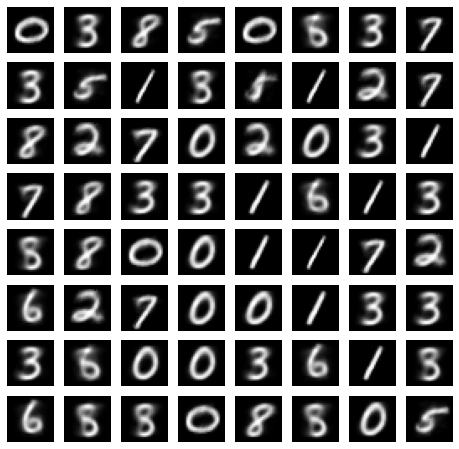

In [ ]:
from random import randrange
R, C = 8, 8
i = 0
plt.figure(figsize= (8,8))
for i in range(64):
  c = randrange(10)
  point = x[y == c][1].to(device)
  z = vae2D.encoder(point) # équivaut à .flatten
  plt.subplot(R, C, i + 1)
  plt.imshow(to_im(vaer2D.decoder(z)), cmap='gray')
  plt.axis('off')
  i += 1
plt.show()

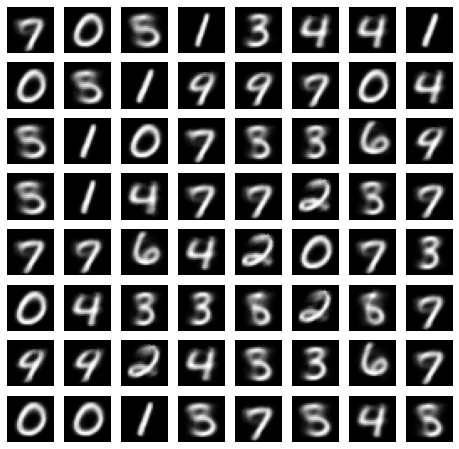

In [ ]:
from random import randrange
R, C = 8, 8
i = 0
plt.figure(figsize= (8,8))
for i in range(64):
  c = randrange(10)
  point = x[y == c][1].to(device)
  z = vaer2D.encoder(point) # équivaut à .flatten
  plt.subplot(R, C, i + 1)
  plt.imshow(to_im(vaer2D.decoder(z)), cmap='gray')
  plt.axis('off')
  i += 1
plt.show()

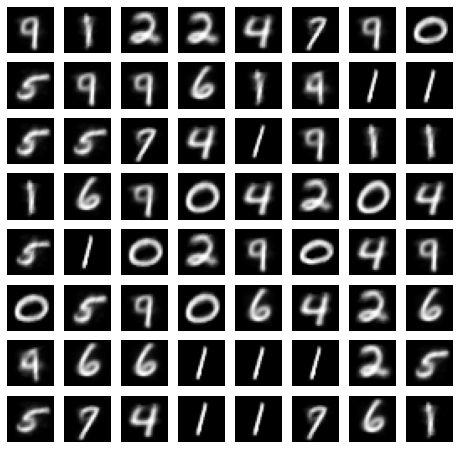

In [ ]:
from random import randrange
R, C = 8, 8
i = 0
plt.figure(figsize= (8,8))
for i in range(64):
  c = randrange(10)
  point = x[y == c][1].to(device)
  z = vaet2D.encoder(point) # équivaut à .flatten
  plt.subplot(R, C, i + 1)
  plt.imshow(to_im(vaer2D.decoder(z)), cmap='gray')
  plt.axis('off')
  i += 1
plt.show()

# Interpolation

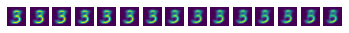

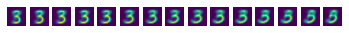

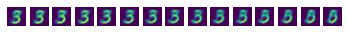

In [ ]:
plt.subplot(1,3,1)
plot_interpolation(vae2D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,3,2)
plot_interpolation(vaer2D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,3,3)
plot_interpolation(vaet2D, c1 = 3, c2 = 5, n_steps = 15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


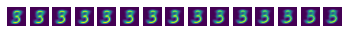

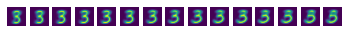

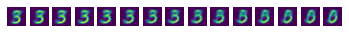

In [ ]:
plt.subplot(1,3,1)
plot_spherical_interpolation(vae2D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,3,2)
plot_spherical_interpolation(vaer2D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,3,3)
plot_spherical_interpolation(vaet2D, c1 = 3, c2 = 5, n_steps = 15)

In [22]:
PATH = '/content/drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae/Ilan_Train/trained_VAE_Relu_100_epochs_10D.pt'
vaer10D = torch.load(PATH)
print(vaer10D.eval())

PATH = '/content/drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae/Ilan_Train/trained_VAE_Relu_100_epochs_50D.pt'
vaer50D = torch.load(PATH)
print(vaer50D.eval())

PATH = '/content/drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae/Ilan_Train/trained_VAE_Relu_100_epochs_100D.pt'
vaer100D = torch.load(PATH)
print(vaer100D.eval())

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=10, bias=True)
    (linear3): Linear(in_features=512, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=10, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)
VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=50, bias=True)
    (linear3): Linear(in_features=512, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=50, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)
VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(i

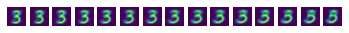

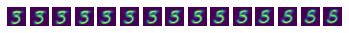

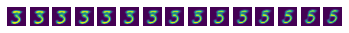

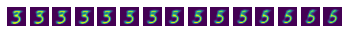

In [ ]:
plt.subplot(1,4,1)
plot_interpolation(vaer2D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,4,2)
plot_interpolation(vaer10D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,4,3)
plot_interpolation(vaer50D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,4,4)
plot_interpolation(vaer100D, c1 = 3, c2 = 5, n_steps = 15)

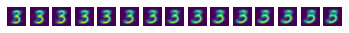

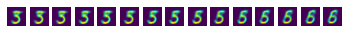

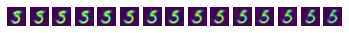

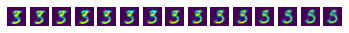

In [ ]:
plt.subplot(1,4,1)
plot_spherical_interpolation(vaer2D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,4,2)
plot_spherical_interpolation(vaer10D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,4,3)
plot_spherical_interpolation(vaer50D, c1 = 3, c2 = 5, n_steps = 15)
plt.subplot(1,4,4)
plot_spherical_interpolation(vaer100D, c1 = 3, c2 = 5, n_steps = 15)

# Grilles selon les dimensions

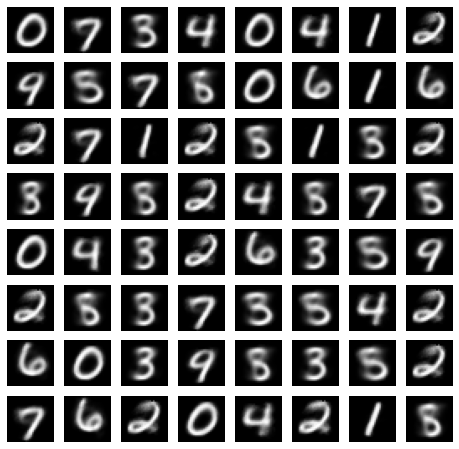

In [ ]:
from random import randrange
R, C = 8, 8
i = 0
plt.figure(figsize= (8,8))
for i in range(64):
  c = randrange(10)
  point = x[y == c][1].to(device)
  z = vaer2D.encoder(point) # équivaut à .flatten
  plt.subplot(R, C, i + 1)
  plt.imshow(to_im(vaer2D.decoder(z)), cmap='gray')
  plt.axis('off')
  i += 1
plt.show()

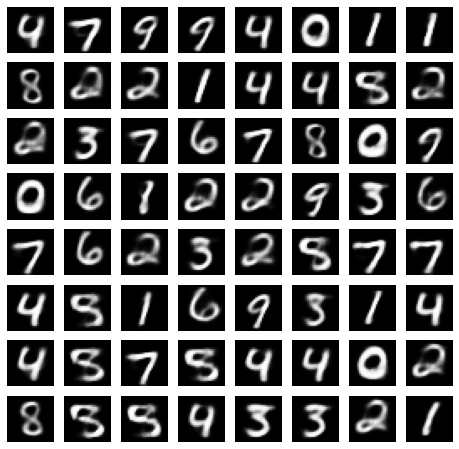

In [ ]:
from random import randrange
R, C = 8, 8
i = 0
plt.figure(figsize= (8,8))
for i in range(64):
  c = randrange(10)
  point = x[y == c][1].to(device)
  z = vaer10D.encoder(point) # équivaut à .flatten
  plt.subplot(R, C, i + 1)
  plt.imshow(to_im(vaer10D.decoder(z)), cmap='gray')
  plt.axis('off')
  i += 1
plt.show()

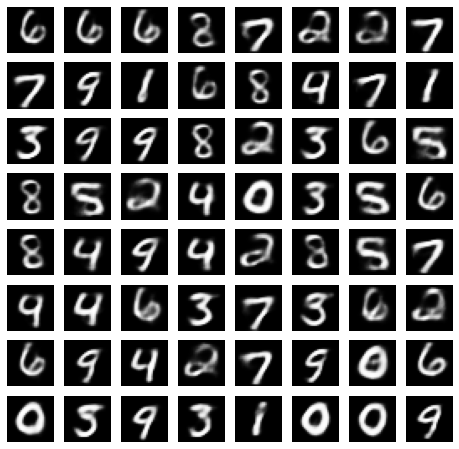

In [ ]:
from random import randrange
R, C = 8, 8
i = 0
plt.figure(figsize= (8,8))
for i in range(64):
  c = randrange(10)
  point = x[y == c][1].to(device)
  z = vaer50D.encoder(point) # équivaut à .flatten
  plt.subplot(R, C, i + 1)
  plt.imshow(to_im(vaer50D.decoder(z)), cmap='gray')
  plt.axis('off')
  i += 1
plt.show()

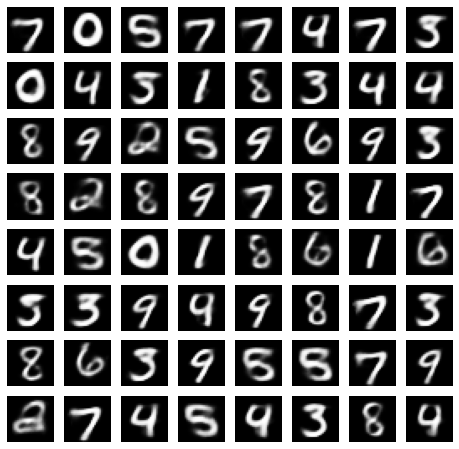

In [ ]:
from random import randrange
R, C = 8, 8
i = 0
plt.figure(figsize= (8,8))
for i in range(64):
  c = randrange(10)
  point = x[y == c][1].to(device)
  z = vaer100D.encoder(point) # équivaut à .flatten
  plt.subplot(R, C, i + 1)
  plt.imshow(to_im(vaer100D.decoder(z)), cmap='gray')
  plt.axis('off')
  i += 1
plt.show()

# Arithmétique de vecteur dans l'espace latent


Coordinates of X1 :  -0.3593 ,  0.1178
Coordinates of X2 :  0.3694 ,  -1.4612
Coordinates of X3 :  0.8096 ,  -0.6361
Coordinates of X1 + X2 :  0.0101 ,  -1.3434
Coordinates of X1 + X2 - X3 :  -0.7995 ,  -0.7073


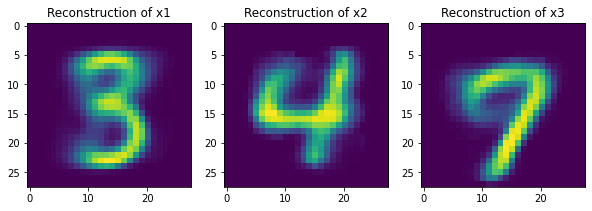

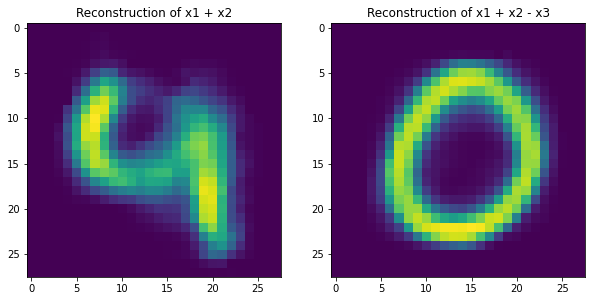

In [ ]:
x1 = x[y == 3][1].to(device) # find a 0
x2 = x[y == 4][1].to(device) # find a 4
x3 = x[y == 7][1].to(device) # find a 7

vectorArithmetics(vaer2D, x1, x2, x3)

# Représentation de l'espace latent en fonction des fonctions d'activation

On se fixe à 2 dimensions et on varie les fonctions d'activation (ReLU, Sigmoide, Tanh)

Text(0.5, 1.0, "Représentation des données dans l'espace latent en 2D avec Sigmoid")

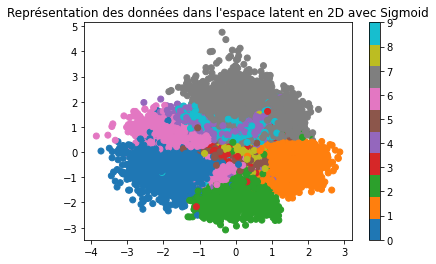

In [ ]:
plot_latent(vae2D, data)
plt.title('Représentation des données dans l\'espace latent en 2D avec Sigmoid')

Text(0.5, 1.0, "Représentation des données dans l'espace latent en 2D avec ReLU")

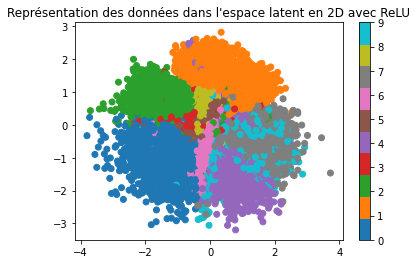

In [ ]:
plot_latent(vaer2D, data)
plt.title('Représentation des données dans l\'espace latent en 2D avec ReLU')

Text(0.5, 1.0, "Représentation des données dans l'espace latent en 2D avec TanH")

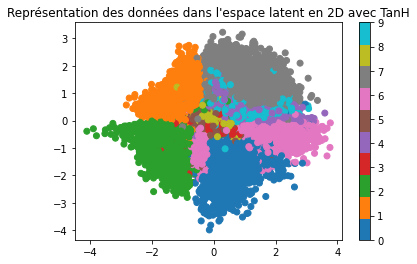

In [ ]:
plot_latent(vaet2D, data)
plt.title('Représentation des données dans l\'espace latent en 2D avec TanH')

# Représentation de l'espace latent en fonction des dimensions

Variation de la dimension de l'espace latent : 2D, 10D, 50D, 100D.

On utilise ReLU comme fonction d'activation.

Text(0.5, 1.0, "Représentation des données dans l'espace latent en 2D")

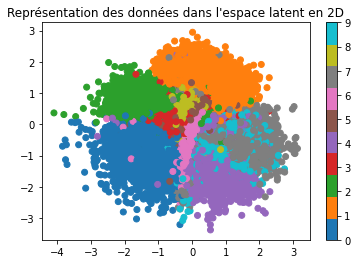

In [ ]:
plot_latent(vaer2D, data)
plt.title('Représentation des données dans l\'espace latent en 2D')

In [27]:
print(img.shape)

(2240, 2240)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 10.061006307601929 seconds


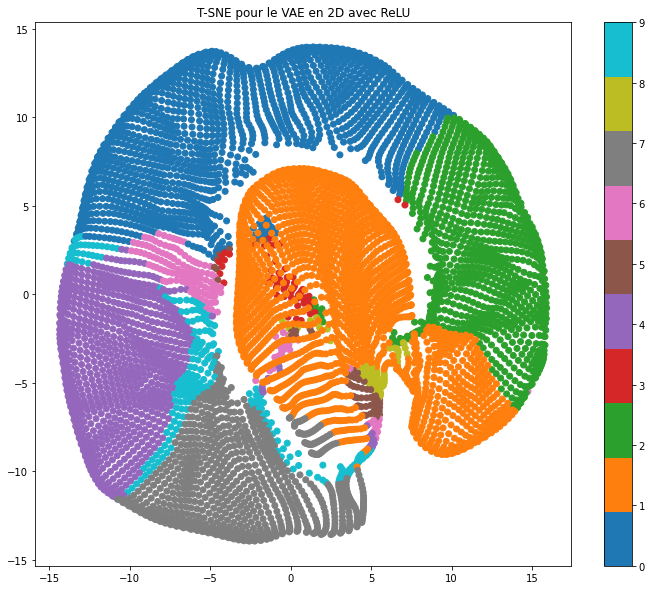

In [28]:
import time
from sklearn.manifold import TSNE

r0 = (-3, 3)
r1 = (-3, 3)
n = 80
latent_size = 2
img, prediction_square, prediction = space_representation_multiD(vaer2D, r0=r0, r1=r1, n=n, latent_size=latent_size)

images = []
labels = []
for i in range(n):
  for j in range(n):
    images.append(img[28*i:28*(i+1), 28*j:28*(j+1)])
    labels.append(prediction_square[i, j])

flattened_images = [i.flatten() for i in images]

time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(flattened_images)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(12,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=prediction, cmap='tab10')
plt.colorbar()
plt.title('T-SNE pour le VAE en 2D avec ReLU')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 11.422190427780151 seconds


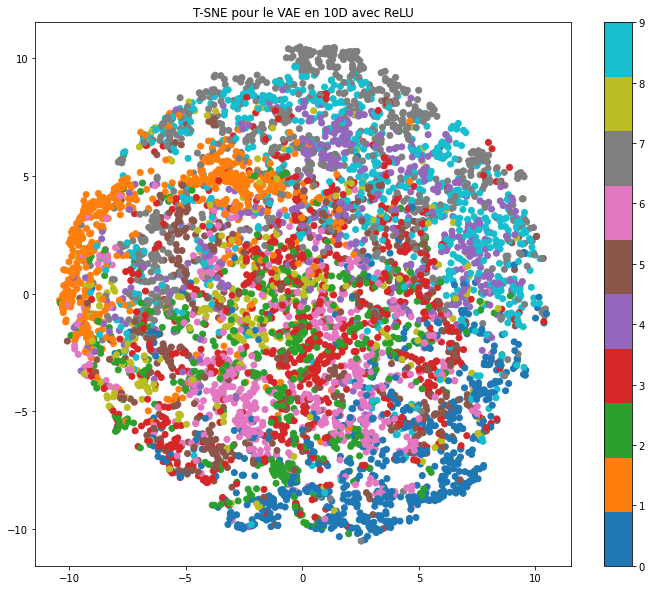

In [ ]:
import time
from sklearn.manifold import TSNE

r0 = (-3, 3)
r1 = (-3, 3)
n = 80
latent_size = 10
img, prediction_square, prediction = space_representation_multiD(vaer10D, r0=r0, r1=r1, n=n, latent_size=latent_size)

images = []
labels = []
for i in range(n*n):
    images.append(img[i, :])
for i in range(n):
  for j in range(n):
    labels.append(prediction_square[i, j])

flattened_images = [i.flatten() for i in images]

time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(flattened_images)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(12,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=prediction, cmap='tab10')
plt.colorbar()
plt.title('T-SNE pour le VAE en 10D avec ReLU')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 10.090659379959106 seconds


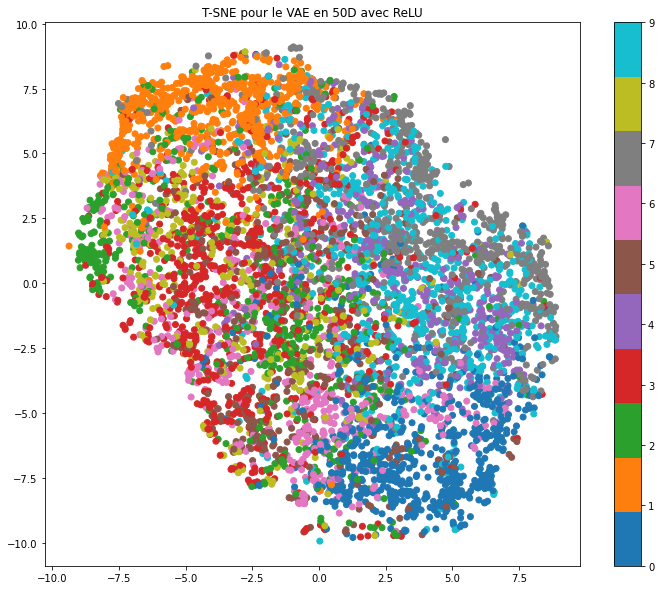

In [ ]:
import time
from sklearn.manifold import TSNE

r0 = (-3, 3)
r1 = (-3, 3)
n = 80
latent_size = 50
img, prediction_square, prediction = space_representation_multiD(vaer50D, r0=r0, r1=r1, n=n, latent_size=latent_size)

images = []
labels = []
for i in range(n*n):
    images.append(img[i, :])
for i in range(n):
  for j in range(n):
    labels.append(prediction_square[i, j])

flattened_images = [i.flatten() for i in images]

time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(flattened_images)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(12,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=prediction, cmap='tab10')
plt.colorbar()
plt.title('T-SNE pour le VAE en 50D avec ReLU')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 12.476418256759644 seconds


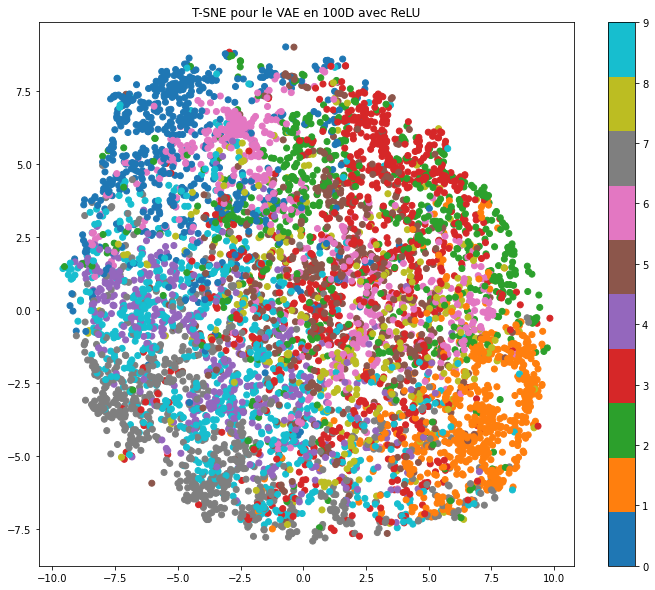

In [ ]:
import time
from sklearn.manifold import TSNE

r0 = (-3, 3)
r1 = (-3, 3)
n = 80
latent_size = 100
img, prediction_square, prediction = space_representation_multiD(vaer100D, r0=r0, r1=r1, n=n, latent_size=latent_size)

images = []
labels = []
for i in range(n*n):
    images.append(img[i, :])
for i in range(n):
  for j in range(n):
    labels.append(prediction_square[i, j])

flattened_images = [i.flatten() for i in images]

time_start = time.time()
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(flattened_images)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.figure(figsize=(12,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=prediction, cmap='tab10')
plt.colorbar()
plt.title('T-SNE pour le VAE en 100D avec ReLU')
plt.show()

# Représentation de l'espace latent avec interpolation

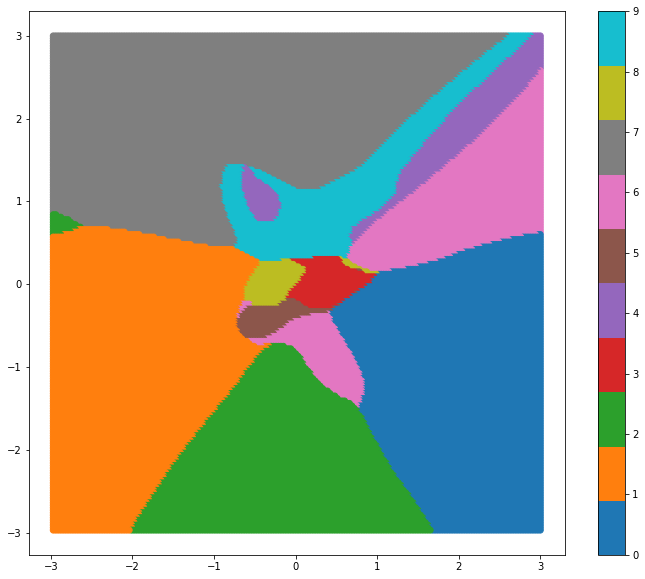

In [ ]:
r0 = (-3, 3)
r1 = (-3, 3)
n = 200
img, pred_square, pred = space_representation(vae2D, r0=r0, r1=r1, n=n)
plot_space_representation_basic(pred_square, r0, r1, n)
# Représentation de l'espace latent avec interpolation - Sigmoide

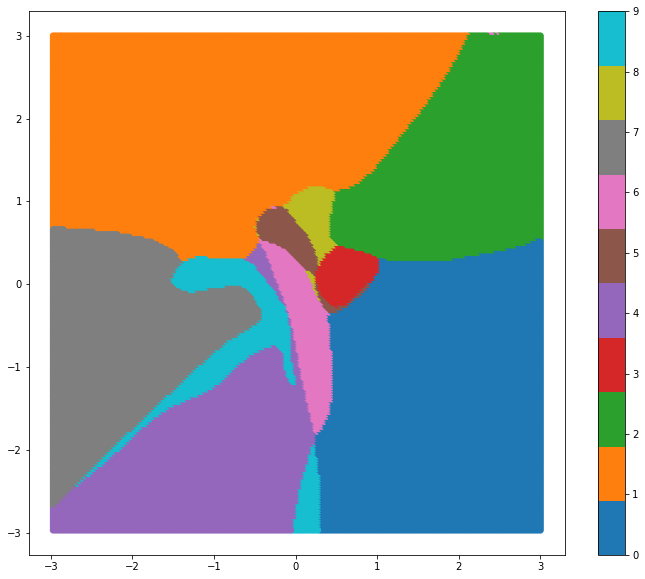

In [ ]:
img, pred_square, pred = space_representation(vaer2D, r0=r0, r1=r1, n=n)
plot_space_representation_basic(pred_square, r0, r1, n)
# Représentation de l'espace latent avec interpolation - ReLU

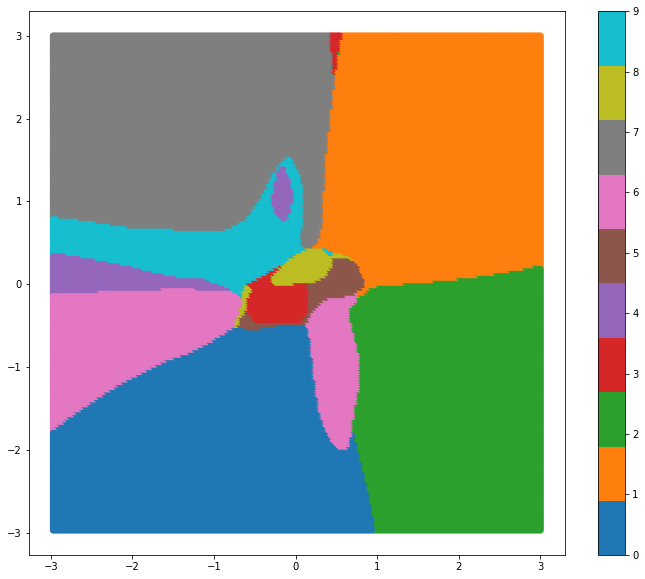

In [ ]:
img, pred_square, pred = space_representation(vaet2D, r0=r0, r1=r1, n=n)
plot_space_representation_basic(pred_square, r0, r1, n)
# Représentation de l'espace latent avec interpolation - TanH